In [1]:
import warnings
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.dummy import DummyClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn import model_selection, naive_bayes, svm
from sklearn.metrics import accuracy_score, classification_report
from sklearn.metrics import ConfusionMatrixDisplay, RocCurveDisplay
from sklearn.metrics import confusion_matrix, roc_curve, auc
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from imblearn.pipeline import Pipeline
from imblearn.combine import SMOTETomek
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import TomekLinks
from sklearn.model_selection import train_test_split, GridSearchCV
from collections import Counter, defaultdict
import nltk
from nltk import word_tokenize
from nltk import pos_tag
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer, WordNetLemmatizer
from nltk.corpus import wordnet as wn
from wordcloud import WordCloud
nltk.download('wordnet')
nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger_eng')
nltk.download('tagsets_json')

# remove warnings
warnings.filterwarnings('ignore')


[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\CDUNGCA\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\CDUNGCA\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\CDUNGCA\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\CDUNGCA\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     C:\Users\CDUNGCA\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger_eng is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package tagsets_json to
[nltk_data]     C:\Users\CDUNGCA\AppData\Roaming\nltk_data...
[nltk_data]   Package tagsets_j

In [2]:
np.random.seed(500)

In [3]:
# Load the data
Corpus = pd.read_csv('data/data.csv')

In [4]:
Corpus.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 194 entries, 0 to 193
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   category  194 non-null    object
 1   fulltext  189 non-null    object
dtypes: object(2)
memory usage: 3.2+ KB


In [5]:
Corpus.head()

,category,fulltext
0,accountability,United Nations A/60/846/Add.6 Gener...
1,accountability,United Nations A/71/729 General Asse...
2,accountability,United Nations A/72/492 General Asse...
3,accountability,United Nations A/72/492/Add.2 Genera...
4,accountability,United Nations A/73/688 General Asse...


In [6]:
Corpus["category"].value_counts()

category
travel                  75
human resources         66
accountability          42
health and wellbeing    11
Name: count, dtype: int64

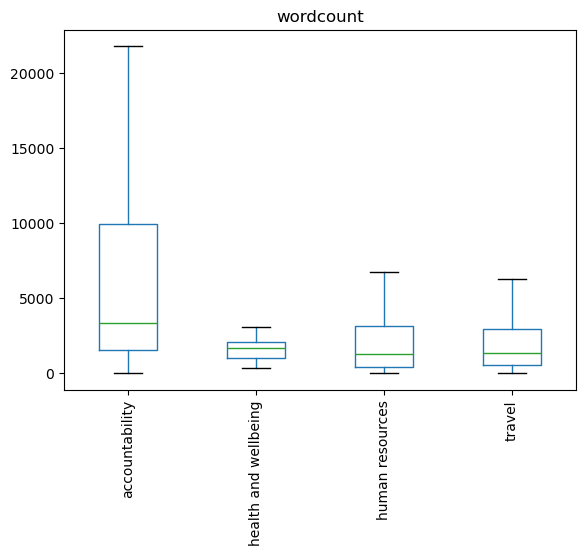

In [7]:
# How long are the texts in the dataset?
Corpus["wordcount"] = Corpus["fulltext"].apply(lambda x: len(str(x).split(" ")))
# plot wordcount per category
Corpus.boxplot("wordcount", by="category", grid=False, showfliers=False)
plt.suptitle("")
plt.xlabel("")
plt.xticks(rotation=90)
plt.show()

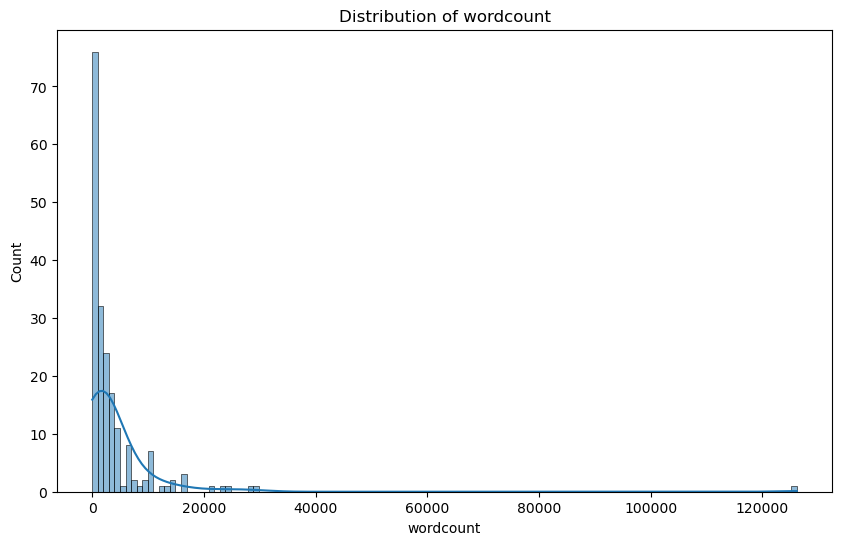

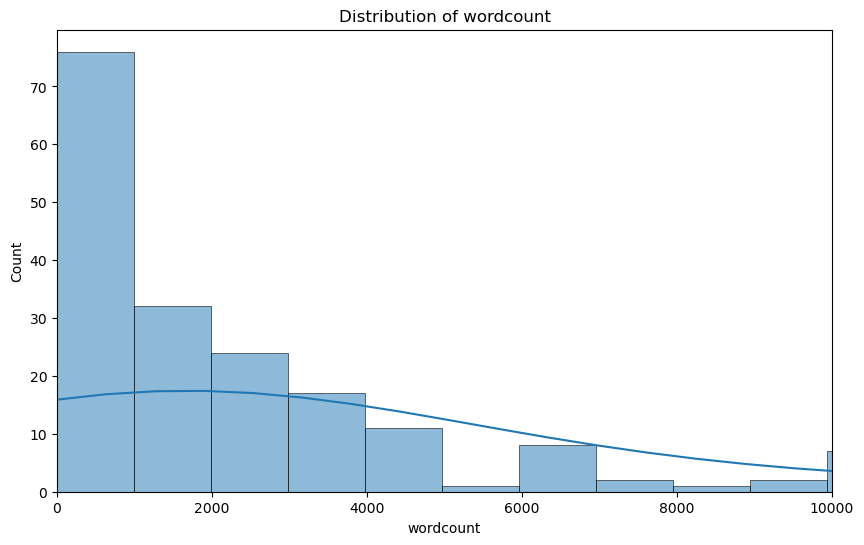

In [8]:
# plot distribution of wordcount
plt.figure(figsize=(10, 6))
sns.histplot(Corpus["wordcount"], kde=True)
plt.title("Distribution of wordcount")
plt.show()
# zoom in on the distribution of wordcount
plt.figure(figsize=(10, 6))
sns.histplot(Corpus["wordcount"], kde=True)
plt.xlim(0, 10000)
plt.title("Distribution of wordcount")
plt.show()


Majority of the documents are less than 5000 words so we will only retain those after data cleaning.

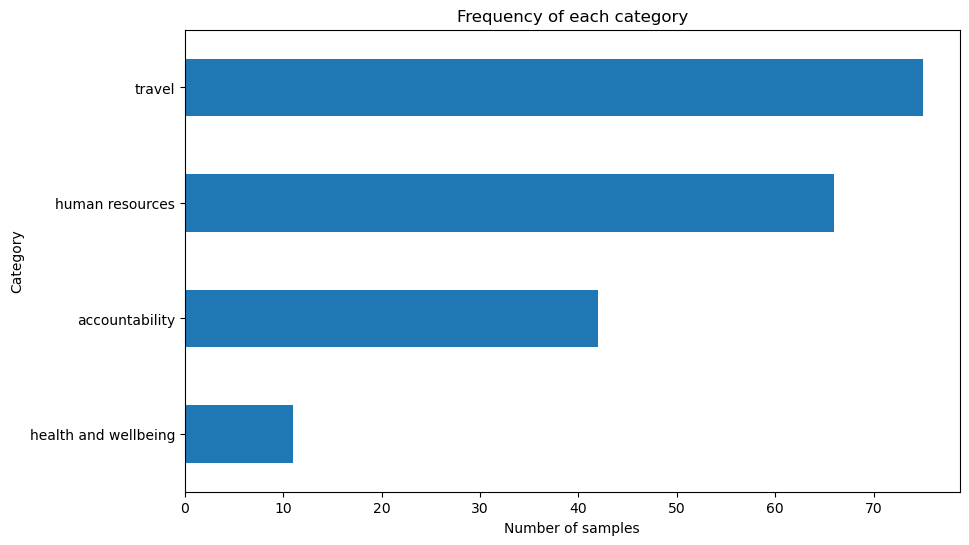

In [9]:
# show category distribution bar horizontal
Corpus["category"].value_counts(ascending=True).plot(kind='barh', figsize=(10, 6))
plt.xlabel('Number of samples')
plt.ylabel('Category')
plt.title('Frequency of each category')
plt.show()


As we can see from the category distribution, we have an imbalance data set. We will have to address before training the model. We will use the F1 score for the metric instead of accuracy.

### Data Pre-processing

1. Remove rows with blank values
Remove rows where wordcount > 5000
2. Change all to lower case
3. Tokenization
4. Remove stop words
5. Remove non-alpha text
6. Word Lemmatization


In [10]:
Corpus.isnull().sum()

category     0
fulltext     5
wordcount    0
dtype: int64

In [11]:
Corpus.dropna(inplace=True)

In [12]:
Corpus.isnull().sum()

category     0
fulltext     0
wordcount    0
dtype: int64

In [13]:
def stemmer(text):
    stem = PorterStemmer()
    return ' '.join([stem.stem(w) for w in word_tokenize(text)])

In [14]:
Corpus['fulltext'] = Corpus['fulltext'].apply(stemmer)

In [15]:
Corpus.head()

,category,fulltext,wordcount
0,accountability,unit nation a/60/846/add.6 gener assembl distr...,8881
1,accountability,unit nation a/71/729 gener assembl distr . : g...,10917
2,accountability,unit nation a/72/492 gener assembl distr . : g...,16716
3,accountability,unit nation a/72/492/add.2 gener assembl distr...,126181
4,accountability,unit nation a/73/688 gener assembl distr . : g...,14427


In [16]:
# Check number of rows for missing values
Corpus.isnull().sum()

category     0
fulltext     0
wordcount    0
dtype: int64

In [17]:
# show record in Corpus with nan values
Corpus[Corpus.isnull().any(axis=1)]

,category,fulltext,wordcount


In [18]:
# Remove rows with empty fields
Corpus = Corpus.dropna()

In [19]:
# Re-check number of rows for missing values
Corpus.isnull().sum()

category     0
fulltext     0
wordcount    0
dtype: int64

In [20]:
Corpus["category"].value_counts()

category
travel                  74
human resources         64
accountability          40
health and wellbeing    11
Name: count, dtype: int64

### Prepare Train and Test Data

In [21]:
# Prepare test data
X_train, X_test, y_train, y_test = train_test_split(Corpus['fulltext'], Corpus['category'], test_size=0.3, stratify=Corpus['category'].values)

In [22]:
# show value counts for training set
y_train.value_counts()

category
travel                  51
human resources         45
accountability          28
health and wellbeing     8
Name: count, dtype: int64

In [23]:
# show value counts for test set
y_test.value_counts()

category
travel                  23
human resources         19
accountability          12
health and wellbeing     3
Name: count, dtype: int64

In [24]:
print('Original dataset shape %s' % Counter(y_train))

Original dataset shape Counter({'travel': 51, 'human resources': 45, 'accountability': 28, 'health and wellbeing': 8})


### Encode category

In [25]:
Encoder = LabelEncoder()
y_train = Encoder.fit_transform(y_train)
y_test = Encoder.fit_transform(y_test)

In [26]:
# Check if all classes are represented in the training set
np.unique(y_train)

array([0, 1, 2, 3])

In [27]:
# Check if all classes are represented in the test set
np.unique(y_test)

array([0, 1, 2, 3])

In [28]:
# Define labels and target names
labels = [0, 1, 2, 3]
target_names = ['accountability', 'health and wellbeing', 'human resources', 'travel']

In [29]:
# Define Pipelines using CountVectorizer

# Baseline
cvect_base_pipeline = Pipeline([('vect', CountVectorizer(stop_words='english', token_pattern=r'\b[^\d\W]+\b')),
                                ('resample', SMOTETomek(sampling_strategy='auto',smote=SMOTE(k_neighbors=2),tomek=TomekLinks())),
                                ('dclass', DummyClassifier(strategy='stratified'))])

# Logistic Regression
cvect_log_pipeline = Pipeline([('vect', CountVectorizer(stop_words='english', token_pattern=r'\b[^\d\W]+\b')),
                               ('resample', SMOTETomek(sampling_strategy='auto',smote=SMOTE(k_neighbors=2),tomek=TomekLinks())),
                               ('log', LogisticRegression(max_iter=10000))])

# Naive Bayes
cvect_nb_pipeline = Pipeline([('vect', CountVectorizer(stop_words='english', token_pattern=r'\b[^\d\W]+\b')),
                              ('resample', SMOTETomek(sampling_strategy='auto',smote=SMOTE(k_neighbors=2),tomek=TomekLinks())),
                              ('nb', MultinomialNB())])

# SVM
cvect_svm_pipeline = Pipeline([('vect', CountVectorizer(stop_words='english', token_pattern=r'\b[^\d\W]+\b')),
                               ('resample', SMOTETomek(sampling_strategy='auto',smote=SMOTE(k_neighbors=2),tomek=TomekLinks())),
                               ('svm', SVC())])

In [30]:
# Define Pipelines using TfidfVectorizer

# Baseline
tvect_base_pipeline = Pipeline([('vect', TfidfVectorizer(stop_words='english', token_pattern=r'\b[^\d\W]+\b')),
                                ('resample', SMOTETomek(sampling_strategy='auto',smote=SMOTE(k_neighbors=2),tomek=TomekLinks())),
                                ('dclass', DummyClassifier(strategy='stratified'))])

# Logistic Regression
tvect_log_pipeline = Pipeline([('vect', TfidfVectorizer(stop_words='english', token_pattern=r'\b[^\d\W]+\b')),
                               ('resample', SMOTETomek(sampling_strategy='auto',smote=SMOTE(k_neighbors=2),tomek=TomekLinks())),
                                ('log', LogisticRegression(max_iter=10000))])

# Naive Bayes
tvect_nb_pipeline = Pipeline([('vect', TfidfVectorizer(stop_words='english', token_pattern=r'\b[^\d\W]+\b')),
                              ('resample', SMOTETomek(sampling_strategy='auto',smote=SMOTE(k_neighbors=2),tomek=TomekLinks())),
                              ('nb', MultinomialNB())])

# SVM
cvect_svm_pipeline = Pipeline([('vect', CountVectorizer(stop_words='english', token_pattern=r'\b[^\d\W]+\b')),
                               ('resample', SMOTETomek(sampling_strategy='auto',smote=SMOTE(k_neighbors=2),tomek=TomekLinks())),
                               ('svm', SVC())])

In [31]:
# Define parameters for GridSearchCV

# CountVectorizer - Logistic Regression
log_param = {'vect__max_features': [100, 500, 1000, 2000],
             'log__C': [0.1, 1, 10, 100]}

# CountVectorizer - Naive Bayes
nb_param = {'vect__max_features': [100, 500, 1000, 2000],
             'nb__alpha': [0.1, 1, 10, 100]}

# CountVectorizer - SVM
svm_param = {'vect__max_features': [100, 500, 1000, 2000],
             'svm__C': [0.1, 1, 10, 100]}

In [32]:
# Function to train and evaluate models
def train_eval_model(pipeline, X_train, y_train, X_test, y_test, target_names, labels):
    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_test)
    print(pipeline.named_steps)
    print(classification_report(y_test, y_pred, target_names=target_names, labels=labels))
    return y_pred
    

In [33]:
# Function to train and tune models
def train_tune_model(pipeline, X_train, y_train, X_test, y_test, target_names, labels, param_grid):
    grid = GridSearchCV(pipeline, param_grid)
    grid.fit(X_train, y_train)
    y_pred = grid.predict(X_test)
    print(pipeline.named_steps)
    print(grid.best_params_)
    print(classification_report(y_test, y_pred, target_names=target_names, labels=labels))
    return y_pred

In [34]:
# Function to confusion matrix
def show_conf_matrix(y_test, y_pred, labels, title):
    conf_matrix = confusion_matrix(y_test, y_pred)
    fig, ax = plt.subplots(figsize=(4, 4))
    disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=labels)
    disp.plot(cmap="Blues", ax=ax, colorbar=False)
    plt.title(title)
    plt.xticks(rotation=90)
    plt.show()

### Evaluate models using CountVectorizer for feature extraction

#### Default parameters

In [35]:
# Baseline
train_eval_model(cvect_base_pipeline, X_train, y_train, X_test, y_test, target_names, labels)

{'vect': CountVectorizer(stop_words='english', token_pattern='\\b[^\\d\\W]+\\b'), 'resample': SMOTETomek(smote=SMOTE(k_neighbors=2), tomek=TomekLinks()), 'dclass': DummyClassifier(strategy='stratified')}
                      precision    recall  f1-score   support

      accountability       0.36      0.42      0.38        12
health and wellbeing       0.07      0.33      0.12         3
     human resources       0.23      0.16      0.19        19
              travel       0.44      0.30      0.36        23

            accuracy                           0.28        57
           macro avg       0.27      0.30      0.26        57
        weighted avg       0.33      0.28      0.29        57



array([1, 3, 1, 2, 1, 0, 2, 2, 0, 1, 2, 1, 0, 3, 1, 1, 3, 0, 3, 0, 3, 1,
       2, 0, 3, 3, 1, 3, 2, 0, 2, 2, 3, 1, 0, 1, 1, 0, 2, 3, 2, 1, 3, 3,
       3, 3, 2, 0, 2, 1, 0, 0, 3, 0, 3, 0, 2])

In [36]:
# Logistic Regression
train_eval_model(cvect_log_pipeline, X_train, y_train, X_test, y_test, target_names, labels)

{'vect': CountVectorizer(stop_words='english', token_pattern='\\b[^\\d\\W]+\\b'), 'resample': SMOTETomek(smote=SMOTE(k_neighbors=2), tomek=TomekLinks()), 'log': LogisticRegression(max_iter=10000)}
                      precision    recall  f1-score   support

      accountability       0.82      0.75      0.78        12
health and wellbeing       0.00      0.00      0.00         3
     human resources       0.62      0.68      0.65        19
              travel       0.75      0.78      0.77        23

            accuracy                           0.70        57
           macro avg       0.55      0.55      0.55        57
        weighted avg       0.68      0.70      0.69        57



array([0, 2, 2, 0, 2, 0, 0, 3, 2, 3, 0, 2, 2, 0, 3, 0, 3, 3, 1, 2, 3, 2,
       2, 2, 2, 3, 2, 3, 2, 2, 3, 2, 3, 3, 3, 3, 3, 3, 3, 3, 2, 2, 3, 2,
       3, 3, 2, 0, 0, 3, 2, 3, 0, 3, 2, 0, 3])

In [37]:
# Naive Bayes
train_eval_model(cvect_nb_pipeline, X_train, y_train, X_test, y_test, target_names, labels)

{'vect': CountVectorizer(stop_words='english', token_pattern='\\b[^\\d\\W]+\\b'), 'resample': SMOTETomek(smote=SMOTE(k_neighbors=2), tomek=TomekLinks()), 'nb': MultinomialNB()}
                      precision    recall  f1-score   support

      accountability       0.83      0.83      0.83        12
health and wellbeing       1.00      0.33      0.50         3
     human resources       0.62      0.53      0.57        19
              travel       0.75      0.91      0.82        23

            accuracy                           0.74        57
           macro avg       0.80      0.65      0.68        57
        weighted avg       0.74      0.74      0.72        57



array([0, 2, 3, 0, 0, 0, 0, 3, 2, 3, 0, 2, 2, 0, 3, 0, 3, 2, 3, 2, 3, 2,
       2, 3, 2, 3, 2, 3, 2, 2, 3, 2, 3, 0, 3, 3, 3, 3, 3, 1, 3, 2, 3, 2,
       3, 3, 3, 0, 3, 3, 2, 3, 3, 3, 0, 0, 3])

In [38]:
# SVM
train_eval_model(cvect_svm_pipeline, X_train, y_train, X_test, y_test, target_names, labels)


{'vect': CountVectorizer(stop_words='english', token_pattern='\\b[^\\d\\W]+\\b'), 'resample': SMOTETomek(smote=SMOTE(k_neighbors=2), tomek=TomekLinks()), 'svm': SVC()}
                      precision    recall  f1-score   support

      accountability       0.89      0.67      0.76        12
health and wellbeing       0.11      0.67      0.18         3
     human resources       0.67      0.11      0.18        19
              travel       0.58      0.65      0.61        23

            accuracy                           0.47        57
           macro avg       0.56      0.52      0.43        57
        weighted avg       0.65      0.47      0.48        57



array([0, 1, 1, 0, 1, 3, 0, 3, 1, 3, 0, 1, 3, 0, 3, 1, 3, 3, 3, 3, 3, 1,
       1, 3, 1, 3, 3, 1, 3, 3, 3, 3, 3, 0, 2, 1, 1, 1, 3, 0, 1, 2, 1, 1,
       3, 3, 1, 0, 3, 3, 3, 3, 1, 1, 2, 0, 3])

#### Tune hyperparameters

In [39]:
# Logistic Regression
train_tune_model(cvect_log_pipeline, X_train, y_train, X_test, y_test, target_names, labels, log_param)

{'vect': CountVectorizer(stop_words='english', token_pattern='\\b[^\\d\\W]+\\b'), 'resample': SMOTETomek(smote=SMOTE(k_neighbors=2), tomek=TomekLinks()), 'log': LogisticRegression(max_iter=10000)}
{'log__C': 0.1, 'vect__max_features': 2000}
                      precision    recall  f1-score   support

      accountability       0.90      0.75      0.82        12
health and wellbeing       0.50      0.33      0.40         3
     human resources       0.62      0.68      0.65        19
              travel       0.79      0.83      0.81        23

            accuracy                           0.74        57
           macro avg       0.70      0.65      0.67        57
        weighted avg       0.74      0.74      0.74        57



array([0, 2, 2, 0, 2, 0, 0, 3, 2, 3, 0, 2, 2, 0, 3, 0, 3, 3, 1, 2, 3, 2,
       2, 3, 2, 3, 2, 3, 2, 2, 3, 2, 3, 3, 3, 2, 3, 3, 3, 1, 2, 2, 3, 2,
       3, 3, 3, 0, 2, 3, 2, 3, 0, 3, 2, 0, 3])

In [40]:
# Naive Bayes
train_tune_model(cvect_nb_pipeline, X_train, y_train, X_test, y_test, target_names, labels, nb_param)

{'vect': CountVectorizer(stop_words='english', token_pattern='\\b[^\\d\\W]+\\b'), 'resample': SMOTETomek(smote=SMOTE(k_neighbors=2), tomek=TomekLinks()), 'nb': MultinomialNB()}
{'nb__alpha': 1, 'vect__max_features': 1000}
                      precision    recall  f1-score   support

      accountability       0.83      0.83      0.83        12
health and wellbeing       1.00      0.33      0.50         3
     human resources       0.62      0.53      0.57        19
              travel       0.75      0.91      0.82        23

            accuracy                           0.74        57
           macro avg       0.80      0.65      0.68        57
        weighted avg       0.74      0.74      0.72        57



array([0, 2, 3, 0, 0, 0, 0, 3, 2, 3, 0, 2, 2, 0, 3, 0, 3, 2, 3, 2, 3, 2,
       2, 3, 2, 3, 2, 3, 2, 2, 3, 2, 3, 0, 3, 3, 3, 3, 3, 1, 3, 2, 3, 2,
       3, 3, 3, 0, 3, 3, 2, 3, 3, 3, 0, 0, 3])

In [41]:
# SVM
train_tune_model(cvect_svm_pipeline, X_train, y_train, X_test, y_test, target_names, labels, svm_param)

{'vect': CountVectorizer(stop_words='english', token_pattern='\\b[^\\d\\W]+\\b'), 'resample': SMOTETomek(smote=SMOTE(k_neighbors=2), tomek=TomekLinks()), 'svm': SVC()}
{'svm__C': 10, 'vect__max_features': 1000}
                      precision    recall  f1-score   support

      accountability       0.90      0.75      0.82        12
health and wellbeing       0.00      0.00      0.00         3
     human resources       0.59      0.68      0.63        19
              travel       0.79      0.83      0.81        23

            accuracy                           0.72        57
           macro avg       0.57      0.57      0.57        57
        weighted avg       0.71      0.72      0.71        57



array([0, 2, 2, 0, 2, 2, 0, 3, 2, 3, 0, 2, 2, 0, 3, 0, 3, 3, 1, 2, 3, 2,
       2, 3, 2, 3, 2, 3, 3, 2, 3, 2, 3, 0, 3, 3, 3, 3, 3, 0, 2, 2, 3, 2,
       3, 2, 3, 0, 2, 3, 2, 3, 2, 3, 2, 0, 3])

### Evaluate models using TfidfVectorizer feature extraction

#### Default parameters

In [42]:
# Baseline
train_eval_model(tvect_base_pipeline, X_train, y_train, X_test, y_test, target_names, labels)

{'vect': TfidfVectorizer(stop_words='english', token_pattern='\\b[^\\d\\W]+\\b'), 'resample': SMOTETomek(smote=SMOTE(k_neighbors=2), tomek=TomekLinks()), 'dclass': DummyClassifier(strategy='stratified')}
                      precision    recall  f1-score   support

      accountability       0.20      0.25      0.22        12
health and wellbeing       0.15      0.67      0.25         3
     human resources       0.46      0.32      0.38        19
              travel       0.44      0.30      0.36        23

            accuracy                           0.32        57
           macro avg       0.31      0.38      0.30        57
        weighted avg       0.38      0.32      0.33        57



array([0, 0, 3, 2, 0, 3, 3, 3, 3, 3, 0, 1, 1, 3, 1, 2, 1, 1, 1, 2, 2, 2,
       3, 1, 0, 0, 3, 1, 2, 3, 1, 2, 3, 0, 3, 2, 0, 0, 0, 1, 0, 2, 2, 0,
       2, 3, 3, 1, 2, 0, 1, 0, 3, 1, 0, 3, 2])

In [43]:
# Logistic Regression
train_eval_model(tvect_log_pipeline, X_train, y_train, X_test, y_test, target_names, labels)

{'vect': TfidfVectorizer(stop_words='english', token_pattern='\\b[^\\d\\W]+\\b'), 'resample': SMOTETomek(smote=SMOTE(k_neighbors=2), tomek=TomekLinks()), 'log': LogisticRegression(max_iter=10000)}
                      precision    recall  f1-score   support

      accountability       0.91      0.83      0.87        12
health and wellbeing       0.67      0.67      0.67         3
     human resources       0.72      0.68      0.70        19
              travel       0.84      0.91      0.88        23

            accuracy                           0.81        57
           macro avg       0.78      0.77      0.78        57
        weighted avg       0.81      0.81      0.81        57



array([0, 2, 3, 0, 0, 2, 0, 3, 2, 3, 0, 2, 2, 0, 3, 0, 3, 3, 1, 2, 3, 2,
       1, 3, 2, 3, 2, 3, 2, 2, 3, 2, 3, 0, 3, 3, 3, 3, 3, 1, 2, 2, 3, 2,
       3, 3, 3, 0, 2, 3, 0, 3, 2, 3, 2, 0, 3])

In [44]:
# Naive Bayes
train_eval_model(tvect_nb_pipeline, X_train, y_train, X_test, y_test, target_names, labels)

{'vect': TfidfVectorizer(stop_words='english', token_pattern='\\b[^\\d\\W]+\\b'), 'resample': SMOTETomek(smote=SMOTE(k_neighbors=2), tomek=TomekLinks()), 'nb': MultinomialNB()}
                      precision    recall  f1-score   support

      accountability       0.63      1.00      0.77        12
health and wellbeing       1.00      0.67      0.80         3
     human resources       0.90      0.47      0.62        19
              travel       0.81      0.91      0.86        23

            accuracy                           0.77        57
           macro avg       0.83      0.76      0.76        57
        weighted avg       0.81      0.77      0.76        57



array([0, 2, 3, 0, 0, 0, 0, 3, 0, 3, 0, 0, 2, 0, 3, 0, 3, 0, 3, 0, 3, 2,
       1, 3, 2, 3, 2, 3, 0, 2, 3, 2, 3, 0, 3, 3, 3, 3, 3, 1, 2, 2, 3, 2,
       3, 3, 3, 0, 3, 3, 0, 3, 0, 3, 0, 0, 3])

In [45]:
# SVM
train_eval_model(cvect_svm_pipeline, X_train, y_train, X_test, y_test, target_names, labels)

{'vect': CountVectorizer(stop_words='english', token_pattern='\\b[^\\d\\W]+\\b'), 'resample': SMOTETomek(smote=SMOTE(k_neighbors=2), tomek=TomekLinks()), 'svm': SVC()}
                      precision    recall  f1-score   support

      accountability       0.88      0.58      0.70        12
health and wellbeing       0.07      0.67      0.13         3
     human resources       0.67      0.11      0.18        19
              travel       0.61      0.48      0.54        23

            accuracy                           0.39        57
           macro avg       0.56      0.46      0.39        57
        weighted avg       0.66      0.39      0.43        57



array([0, 1, 1, 0, 1, 3, 0, 3, 1, 3, 0, 1, 1, 0, 3, 1, 3, 1, 3, 1, 1, 1,
       1, 3, 1, 1, 3, 1, 3, 3, 3, 1, 3, 3, 2, 1, 1, 1, 3, 0, 1, 2, 1, 1,
       1, 1, 1, 0, 3, 3, 1, 3, 1, 1, 2, 0, 3])

#### Tune hyperparameters

In [46]:
# Logistic Regression
train_tune_model(tvect_log_pipeline, X_train, y_train, X_test, y_test, target_names, labels, log_param)

{'vect': TfidfVectorizer(stop_words='english', token_pattern='\\b[^\\d\\W]+\\b'), 'resample': SMOTETomek(smote=SMOTE(k_neighbors=2), tomek=TomekLinks()), 'log': LogisticRegression(max_iter=10000)}
{'log__C': 1, 'vect__max_features': 500}
                      precision    recall  f1-score   support

      accountability       0.92      0.92      0.92        12
health and wellbeing       1.00      0.67      0.80         3
     human resources       0.72      0.68      0.70        19
              travel       0.80      0.87      0.83        23

            accuracy                           0.81        57
           macro avg       0.86      0.78      0.81        57
        weighted avg       0.81      0.81      0.81        57



array([0, 2, 3, 0, 0, 0, 0, 3, 2, 3, 0, 2, 2, 0, 3, 0, 3, 3, 3, 2, 3, 2,
       1, 3, 2, 3, 2, 3, 2, 2, 3, 2, 3, 0, 3, 3, 3, 3, 3, 1, 2, 2, 3, 2,
       3, 2, 3, 0, 2, 3, 0, 3, 2, 3, 2, 0, 3])

In [47]:
# Naive Bayes
train_tune_model(tvect_nb_pipeline, X_train, y_train, X_test, y_test, target_names, labels, nb_param)

{'vect': TfidfVectorizer(stop_words='english', token_pattern='\\b[^\\d\\W]+\\b'), 'resample': SMOTETomek(smote=SMOTE(k_neighbors=2), tomek=TomekLinks()), 'nb': MultinomialNB()}
{'nb__alpha': 0.1, 'vect__max_features': 2000}
                      precision    recall  f1-score   support

      accountability       0.85      0.92      0.88        12
health and wellbeing       1.00      1.00      1.00         3
     human resources       0.80      0.63      0.71        19
              travel       0.81      0.91      0.86        23

            accuracy                           0.82        57
           macro avg       0.86      0.87      0.86        57
        weighted avg       0.82      0.82      0.82        57



array([0, 2, 3, 0, 0, 0, 0, 3, 2, 3, 0, 1, 2, 0, 3, 0, 3, 3, 3, 2, 3, 2,
       1, 2, 2, 3, 2, 3, 2, 2, 3, 2, 3, 0, 3, 3, 3, 3, 3, 1, 2, 2, 3, 2,
       3, 3, 3, 0, 3, 3, 0, 3, 2, 3, 0, 0, 3])

In [48]:
# SVM
train_tune_model(cvect_svm_pipeline, X_train, y_train, X_test, y_test, target_names, labels, svm_param)

{'vect': CountVectorizer(stop_words='english', token_pattern='\\b[^\\d\\W]+\\b'), 'resample': SMOTETomek(smote=SMOTE(k_neighbors=2), tomek=TomekLinks()), 'svm': SVC()}
{'svm__C': 100, 'vect__max_features': 1000}
                      precision    recall  f1-score   support

      accountability       1.00      0.67      0.80        12
health and wellbeing       0.00      0.00      0.00         3
     human resources       0.62      0.68      0.65        19
              travel       0.74      0.87      0.80        23

            accuracy                           0.72        57
           macro avg       0.59      0.56      0.56        57
        weighted avg       0.72      0.72      0.71        57



array([0, 2, 2, 0, 2, 0, 0, 3, 2, 3, 0, 3, 2, 0, 3, 0, 3, 3, 1, 2, 3, 2,
       3, 3, 2, 3, 2, 3, 3, 2, 3, 2, 3, 2, 3, 3, 3, 3, 3, 2, 2, 2, 3, 2,
       3, 3, 3, 2, 2, 3, 2, 3, 2, 3, 2, 0, 3])

{'vect': TfidfVectorizer(stop_words='english', token_pattern='\\b[^\\d\\W]+\\b'), 'resample': SMOTETomek(smote=SMOTE(k_neighbors=2), tomek=TomekLinks()), 'nb': MultinomialNB()}
{'nb__alpha': 0.1, 'vect__max_features': 500}
                      precision    recall  f1-score   support

      accountability       0.82      0.75      0.78        12
health and wellbeing       1.00      0.67      0.80         3
     human resources       0.65      0.58      0.61        19
              travel       0.78      0.91      0.84        23

            accuracy                           0.75        57
           macro avg       0.81      0.73      0.76        57
        weighted avg       0.75      0.75      0.75        57



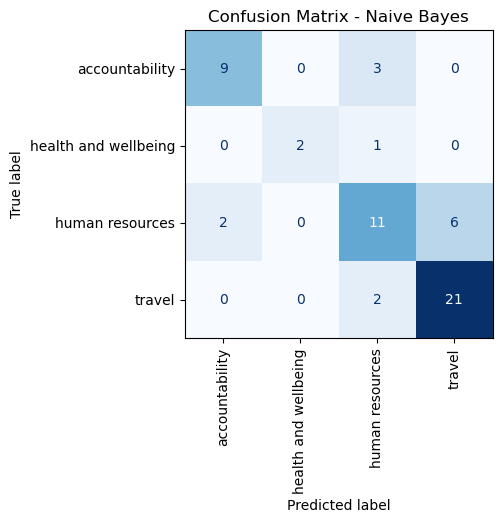

In [49]:
show_conf_matrix(y_test, \
    train_tune_model(tvect_nb_pipeline, X_train, y_train, X_test, y_test, target_names, labels, nb_param), \
        target_names, 'Confusion Matrix - Naive Bayes')